Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [13]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [14]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/'  #changing dir to project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset 

## To Do Code ->

data_dir_train = pathlib.Path( root_path + "Train" )
data_dir_test = pathlib.Path( root_path + "Test" )

In [21]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2246
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [22]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [23]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

## Todo Code ->

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,                       
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2246 files belonging to 9 classes.
Using 1797 files for training.


In [24]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

## Todo Code ->

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2246 files belonging to 9 classes.
Using 449 files for validation.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

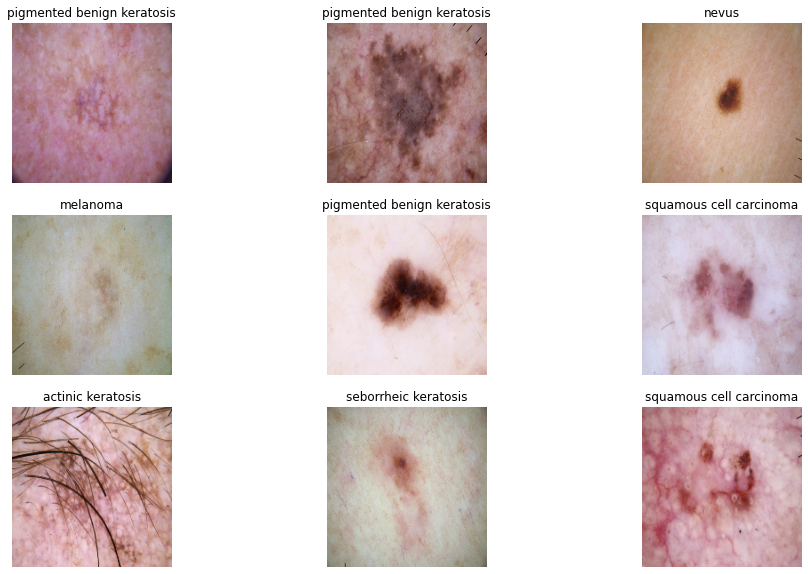

In [26]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

## Todo code ->
plt.figure(figsize=(16, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [30]:
### Your code goes here

## Todo code ->

# standerdizing Values
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.034803774 0.9140506


Model 1

In [31]:
# creating first model after normalization
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

Used Adam optimizer and Sparse Categorical Cross entropy as loss function.

In [32]:
### Todo, choose an appropirate optimiser and loss function

### Todo code ->

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

There are total 3,989,801 parameters which all are trainable.

### Train the model

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 7s 77ms/step - loss: 2.0574 - accuracy: 0.2404 - val_loss: 2.0780 - val_accuracy: 0.2027
Epoch 2/20
57/57 [==============================] - 1s 24ms/step - loss: 1.7516 - accuracy: 0.3779 - val_loss: 1.5873 - val_accuracy: 0.4410
Epoch 3/20
57/57 [==============================] - 1s 24ms/step - loss: 1.5095 - accuracy: 0.4864 - val_loss: 1.4707 - val_accuracy: 0.4944
Epoch 4/20
57/57 [==============================] - 1s 24ms/step - loss: 1.4215 - accuracy: 0.5203 - val_loss: 1.3282 - val_accuracy: 0.5234
Epoch 5/20
57/57 [==============================] - 1s 24ms/step - loss: 1.3014 - accuracy: 0.5498 - val_loss: 1.2963 - val_accuracy: 0.5390
Epoch 6/20
57/57 [==============================] - 1s 24ms/step - loss: 1.2165 - accuracy: 0.5687 - val_loss: 1.3457 - val_accuracy: 0.5234
Epoch 7/20
57/57 [==============================] - 1s 23ms/step - loss: 1.1429 - accuracy: 0.6105 - val_loss: 1.4050 - val_accuracy: 0.5056
Epoch 8/20
57

### Visualizing training results

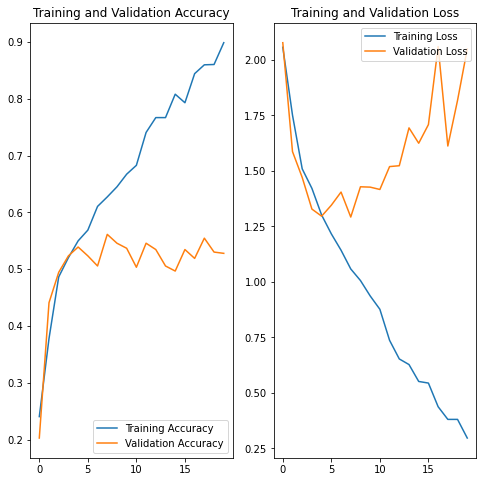

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Observations/Findings :-->


1.   The accuracy of the model is around 80% but the validation accuracy is around 50%.
2.   As the validation accuracy is much lower/differ from train data set it is a sign of overfitting.

To deal with overfitting we can use data augmentation strategies.

1. Using Keras preprocessing layers ( by randomly flipping images and checkig for similarity in images)
2. Using Dropouts (mentioned bellow)

### Write your findings here

In [36]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

# To Do Code ->
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


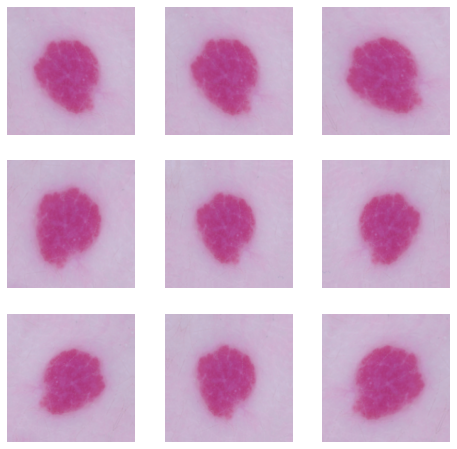

In [37]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

# Todo Code ->
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## To do code (with dropout layer) ->
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [39]:
## To do code ->
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [41]:
## Your code goes here, note: train your model for 20 epochs

# To do code ->

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 2s 30ms/step - loss: 2.0798 - accuracy: 0.2087 - val_loss: 1.9525 - val_accuracy: 0.2829
Epoch 2/20
57/57 [==============================] - 1s 26ms/step - loss: 1.8648 - accuracy: 0.3183 - val_loss: 1.7440 - val_accuracy: 0.3719
Epoch 3/20
57/57 [==============================] - 1s 26ms/step - loss: 1.6977 - accuracy: 0.3912 - val_loss: 1.5190 - val_accuracy: 0.4365
Epoch 4/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4913 - accuracy: 0.4780 - val_loss: 1.3990 - val_accuracy: 0.4878
Epoch 5/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4335 - accuracy: 0.4986 - val_loss: 1.3476 - val_accuracy: 0.5011
Epoch 6/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4274 - accuracy: 0.5031 - val_loss: 1.4881 - val_accuracy: 0.4610
Epoch 7/20
57/57 [==============================] - 1s 26ms/step - loss: 1.3619 - accuracy: 0.5409 - val_loss: 1.2931 - val_accuracy: 0.5523
Epoch 8/20
57

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Finding/Observations

1. There is sudden drop in accuracy of train data set that is from around 80% to around 60%.
2. Accuracy for validation data set in around 60%.
3. both the train and validation accuracy values are not differ by large number and hence it shows that the overfitting of model is reduce at great extent. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                        Class Count
0           actinic keratosis   114
1        basal cell carcinoma   376
2              dermatofibroma    95
3                    melanoma   441
4                       nevus   357
5  pigmented benign keratosis   466
6        seborrheic keratosis    77
7     squamous cell carcinoma   181
8             vascular lesion   139


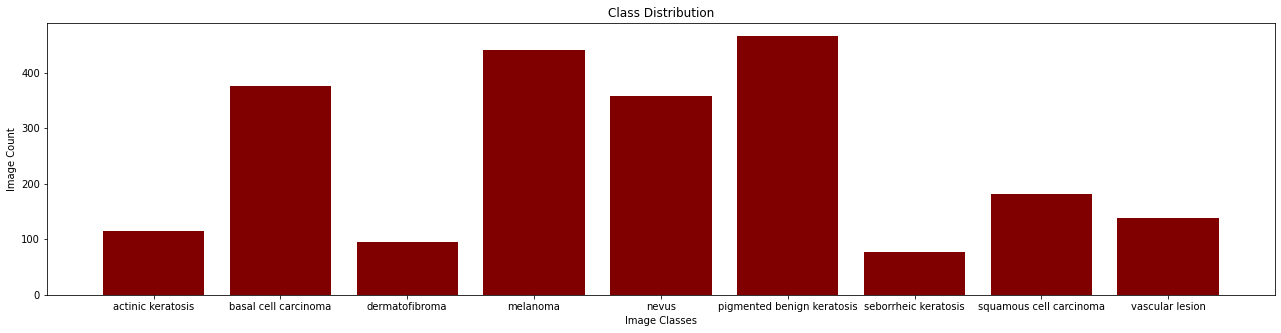

In [42]:
## To do (Class Distribution before handling class imbalance) --?

distributionDs = pd.DataFrame(columns=['Class','Count'])
for sub in class_names:
  imgCount = len(list(data_dir_train.glob(sub+'/*.jpg')))
  distributionDs = distributionDs.append({'Class':sub, 'Count':imgCount}, ignore_index=True)

print(distributionDs.head(10))

fig = plt.figure(figsize = (22, 5))
# creating the bar plot to see distribution
plt.bar(distributionDs.Class, distributionDs.Count, color ='maroon',width = 0.8)
 
plt.xlabel("Image Classes")
plt.ylabel("Image Count")
plt.title("Class Distribution")
plt.show()

#### **Todo:** Write your findings here: 
____________________________________________________________________________
####- Which class has the least number of samples?
#### Answer :-  seborrheic keratosis class is having least number of samples. that is only 77 images.
____________________________________________________________________________
####- Which classes dominate the data in terms proportionate number of samples?
#### Answer :-  Following are the classes which dominates the data most in terms of proportionate number of samples -
1. pigmented benign keratosis
2. melanoma
3. basal cell carcinoma
4. nevus
____________________________________________________________________________

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
path_to_training_dataset= root_path+"Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC1331849D0>: 100%|██████████| 500/500 [00:20<00:00, 24.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC1331A18D0>: 100%|██████████| 500/500 [00:21<00:00, 23.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC1380EDCD0>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 441 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC13829FE90>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x723 at 0x7FC138179DD0>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 466 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC1328B5C90>: 100%|██████████| 500/500 [00:18<00:00, 26.99 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC138659E90>: 100%|██████████| 500/500 [00:43<00:00, 11.38 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC1380ED810>: 100%|██████████| 500/500 [00:18<00:00, 27.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC1328CE810>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
len(path_list)

4500

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
len(lesion_list_new)

4500

In [48]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

                        Class Count
0           actinic keratosis   614
1        basal cell carcinoma   876
2              dermatofibroma   595
3                    melanoma   941
4                       nevus   857
5  pigmented benign keratosis   966
6        seborrheic keratosis   577
7     squamous cell carcinoma   681
8             vascular lesion   639


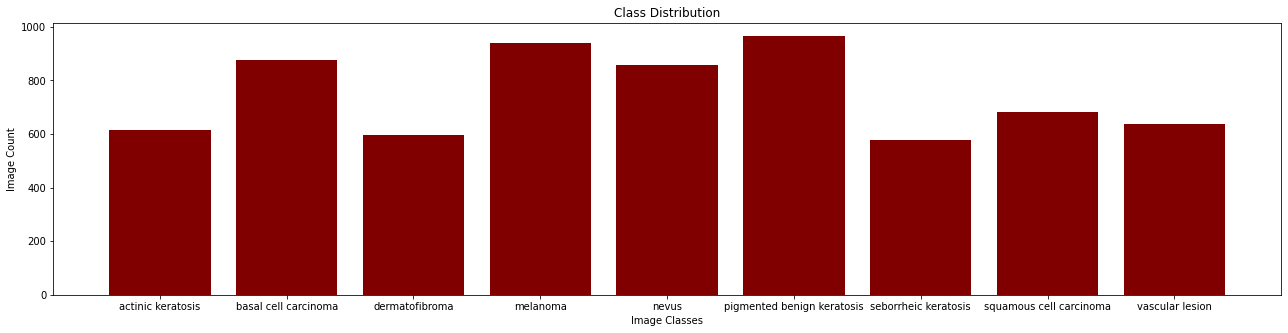

In [49]:
newDistributionDs = pd.DataFrame(columns=['Class','Count'])
for i in class_names:
    directory =root_path +"Train/"+i+'/'
    directory_out =root_path+"Train/"+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    newDistributionDs = newDistributionDs.append({'Class':i, 'Count':length_tot}, ignore_index=True)

print(newDistributionDs.head(10))

fig = plt.figure(figsize = (22, 5))
# creating the bar plot to see distribution
plt.bar(newDistributionDs.Class, newDistributionDs.Count, color ='maroon',width = 0.8)
 
plt.xlabel("Image Classes")
plt.ylabel("Image Count")
plt.title("Class Distribution")
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
data_dir_train=root_path+"Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6746 files belonging to 9 classes.
Using 5397 files for training.


#### **Todo:** Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6746 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

*** Added data augmenttion and dropout to handle overfitting in rebalanced dataset***

In [59]:
## your code goes here

# To do code -->
model_final=Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),
    layers.Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),   
    layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here

# Todo code -->

model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [61]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 32s 178ms/step - loss: 2.2788 - accuracy: 0.2262 - val_loss: 1.8236 - val_accuracy: 0.3714
Epoch 2/30
169/169 [==============================] - 31s 177ms/step - loss: 1.5368 - accuracy: 0.4230 - val_loss: 1.4081 - val_accuracy: 0.4944
Epoch 3/30
169/169 [==============================] - 31s 179ms/step - loss: 1.3323 - accuracy: 0.4969 - val_loss: 1.3818 - val_accuracy: 0.4930
Epoch 4/30
169/169 [==============================] - 31s 176ms/step - loss: 1.1920 - accuracy: 0.5512 - val_loss: 1.1726 - val_accuracy: 0.5678
Epoch 5/30
169/169 [==============================] - 32s 182ms/step - loss: 1.0886 - accuracy: 0.5903 - val_loss: 1.0872 - val_accuracy: 0.6056
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 0.9478 - accuracy: 0.6513 - val_loss: 0.9567 - val_accuracy: 0.6434
Epoch 7/30
169/169 [==============================] - 31s 178ms/step - loss: 0.8268 - accuracy: 0.6950 - val_loss: 0.8722 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

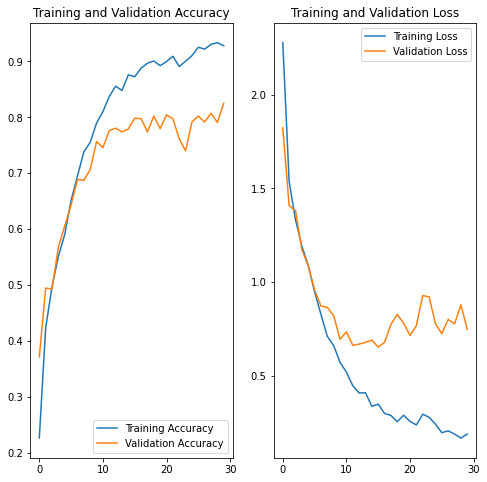

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Observations:-
1. Accuracies on train and validation datasets after class rebalance are around 90% and 80% respectively.
2. For class rebalance i have used oversampling technique in which i have added 500 images per subclass.
3. Training your model on only rebalanced dataset just increase the accuracy to some extent but dosenot help in overfiting/underfitting.
4. Adding dropout layer here helped to reduce some gap between train and validation accuracies but still there is a small gap present which we can fill by data augmentor.
4. predictions for some of the test images is done as below with the confidence level.


## Predictions on Unseen data

In [67]:
# making Predictions on some of test data images
testImgList = list(data_dir_test.glob('*/*.jpg'))
imageArray = []
for i in range(0,20):
  imageArray.append(tf.keras.utils.load_img(testImgList[i], target_size=(img_height, img_width)))

for j in imageArray:
  img_array = tf.keras.utils.img_to_array(j)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to    {}    with a    {:.2f}%   confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

This image most likely belongs to    vascular lesion    with a    99.44%   confidence.
This image most likely belongs to    basal cell carcinoma    with a    36.13%   confidence.
This image most likely belongs to    vascular lesion    with a    99.30%   confidence.
This image most likely belongs to    basal cell carcinoma    with a    42.72%   confidence.
This image most likely belongs to    dermatofibroma    with a    48.61%   confidence.
This image most likely belongs to    actinic keratosis    with a    54.32%   confidence.
This image most likely belongs to    dermatofibroma    with a    66.24%   confidence.
This image most likely belongs to    basal cell carcinoma    with a    47.07%   confidence.
This image most likely belongs to    actinic keratosis    with a    37.95%   confidence.
This image most likely belongs to    basal cell carcinoma    with a    30.09%   confidence.
This image most likely belongs to    basal cell carcinoma    with a    44.22%   confidence.
This image most 